In [23]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score

from tensorflow import keras

from keras.layers import Dense, Flatten, Dropout
from keras.regularizers import l2
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint, EarlyStopping

pd.options.display.float_format = "{:.2f}".format

In [24]:
targetUrl = "https://raw.githubusercontent.com/oprostep/2024-Spring-ML/main/diabetes_prediction_dataset.csv"

df = pd.read_csv(targetUrl, sep=',')
df.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.00,0,1,never,25.19,6.60,140,0
1,Female,54.00,0,0,No Info,27.32,6.60,80,0
2,Male,28.00,0,0,never,27.32,5.70,158,0
3,Female,36.00,0,0,current,23.45,5.00,155,0
4,Male,76.00,1,1,current,20.14,4.80,155,0


In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  int64  
 3   heart_disease        100000 non-null  int64  
 4   smoking_history      100000 non-null  object 
 5   bmi                  100000 non-null  float64
 6   HbA1c_level          100000 non-null  float64
 7   blood_glucose_level  100000 non-null  int64  
 8   diabetes             100000 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 6.9+ MB


In [26]:
df.isna().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64

In [27]:
# 중복 제거
duplicate_rows_data = df[df.duplicated()]
print("number of duplicate rows: ", duplicate_rows_data.shape)

number of duplicate rows:  (3854, 9)


In [28]:
df = df.drop_duplicates()
df.describe().style.format("{:.2f}")

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes
count,96146.00,96146.00,96146.00,96146.00,96146.00,96146.00,96146.00
mean,41.79,0.08,0.04,27.32,5.53,138.22,0.09
std,22.46,0.27,0.20,6.77,1.07,40.91,0.28
min,0.08,0.00,0.00,10.01,3.50,80.00,0.00
25%,24.00,0.00,0.00,23.40,4.80,100.00,0.00
50%,43.00,0.00,0.00,27.32,5.80,140.00,0.00
75%,59.00,0.00,0.00,29.86,6.20,159.00,0.00
max,80.00,1.00,1.00,95.69,9.00,300.00,1.00


In [29]:
# 총 3 군집으로 분류: 비흡연자(흡연경력x), 비흡연자(흡연경력o), 흡연자
def recategorize_smoking(smoking_status):
    if smoking_status in ['never', 'No Info']:
        return 'non-smoker'
    elif smoking_status == 'current':
        return 'current'
    elif smoking_status in ['ever', 'former', 'not current']:
        return 'past_smoker'

# 분류 적용
df['smoking_history'] = df['smoking_history'].apply(recategorize_smoking)
print(df['smoking_history'].value_counts())

smoking_history
non-smoker     67285
past_smoker    19664
current         9197
Name: count, dtype: int64


In [30]:
data = df.copy()

In [31]:
# one-hot encoding
def perform_one_hot_encoding(df, column_name):
    dummies = pd.get_dummies(df[column_name], prefix=column_name)
    df = pd.concat([df.drop(column_name, axis=1), dummies], axis=1)

    return df

# gender와 smoking_history에 적용
data = perform_one_hot_encoding(data, 'gender')
data = perform_one_hot_encoding(data, 'smoking_history')

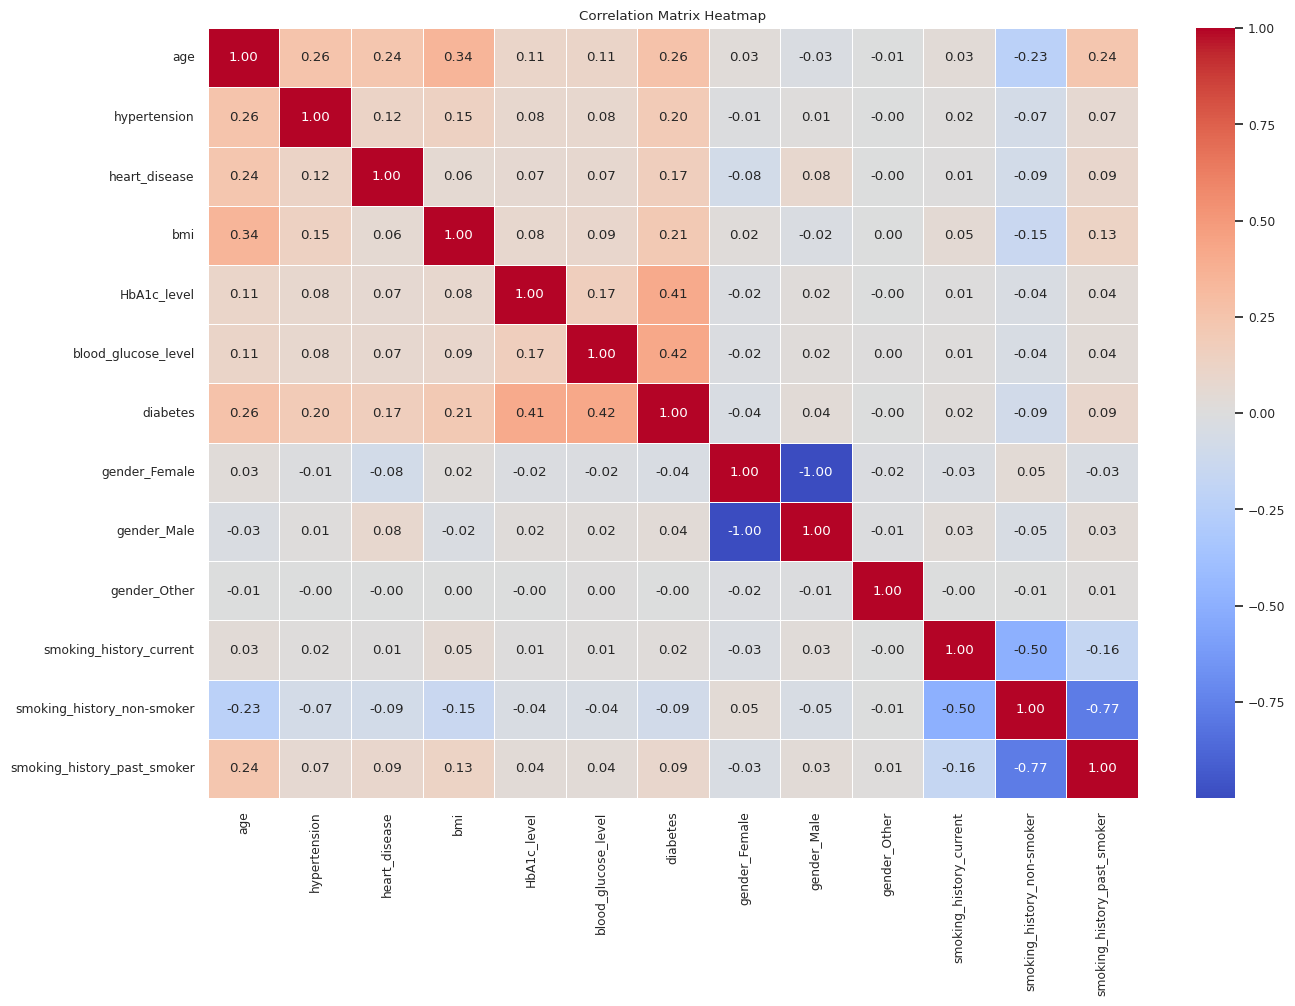

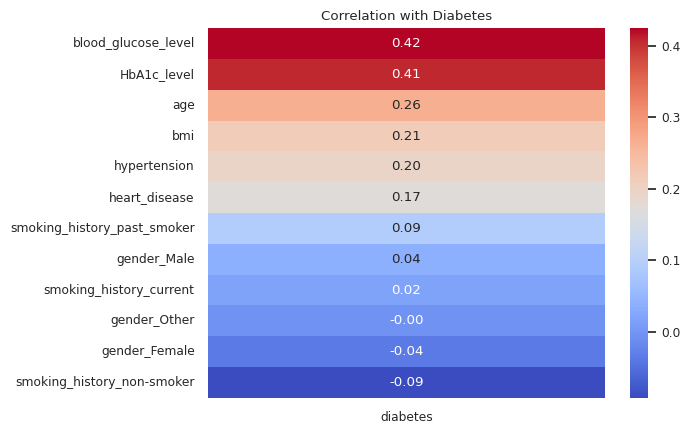

In [32]:
correlation_matrix = data.corr()

# Graph I.
plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, fmt='.2f')
plt.title("Correlation Matrix Heatmap")
plt.show()

# Graph II
corr = data.corr()
target_corr = corr['diabetes'].drop('diabetes')

# 내림차순 정렬
target_corr_sorted = target_corr.sort_values(ascending=False)

sns.set(font_scale=0.8)
sns.set_style("white")
sns.set_palette("PuBuGn_d")
sns.heatmap(target_corr_sorted.to_frame(), cmap="coolwarm", annot=True, fmt='.2f')
plt.title('Correlation with Diabetes')
plt.show()

In [33]:
X = data.iloc[:,:-1].values
y = data.iloc[:,-1].values

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=0)

In [35]:
stand = StandardScaler()
X_train = stand.fit_transform(X_train)
X_test = stand.transform(X_test)

In [36]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors = 5)
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [37]:
y_pred_test = knn.predict(X_test)
accuracy_score(y_test, y_pred_test)

1.0

In [38]:
model = Sequential()
model.add(Dense(6, activation='relu'))
model.add(Dense(6, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=3, verbose=1)
history = model.fit(X_train, y_train, epochs=100, validation_data = (X_test, y_test), callbacks=[early_stop])

Epoch 1/100
2404/2404 [==============================] - 6s 2ms/step - loss: 0.0544 - accuracy: 0.9895 - val_loss: 0.0050 - val_accuracy: 0.9999
Epoch 2/100
2404/2404 [==============================] - 5s 2ms/step - loss: 0.0029 - accuracy: 0.9999 - val_loss: 0.0016 - val_accuracy: 0.9999
Epoch 3/100
2404/2404 [==============================] - 5s 2ms/step - loss: 8.5420e-04 - accuracy: 0.9999 - val_loss: 4.8462e-04 - val_accuracy: 0.9999
Epoch 4/100
2404/2404 [==============================] - 5s 2ms/step - loss: 2.3385e-04 - accuracy: 0.9999 - val_loss: 1.5729e-04 - val_accuracy: 0.9999
Epoch 5/100
2404/2404 [==============================] - 6s 2ms/step - loss: 1.1282e-04 - accuracy: 0.9999 - val_loss: 9.9077e-05 - val_accuracy: 0.9999
Epoch 6/100
2404/2404 [==============================] - 5s 2ms/step - loss: 1.7557e-04 - accuracy: 0.9999 - val_loss: 1.1217e-04 - val_accuracy: 0.9999
Epoch 7/100
2404/2404 [==============================] - 5s 2ms/step - loss: 6.4059e-05 - accuracy

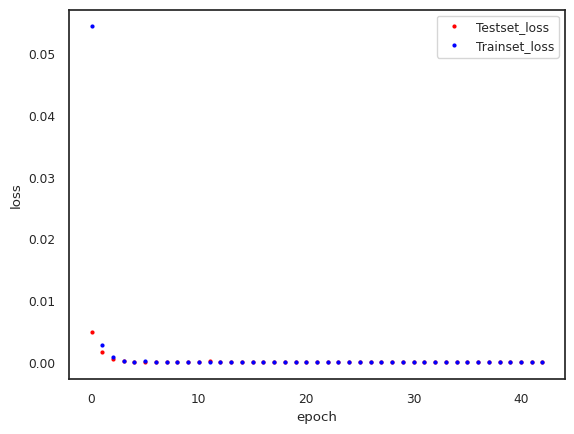

In [39]:
hist_df=pd.DataFrame(history.history)

y_vloss=hist_df['val_loss']
y_loss=hist_df['loss']

x_len = np.arange(len(y_loss))
plt.plot(x_len, y_vloss, "o", c="red", markersize=2, label='Testset_loss')
plt.plot(x_len, y_loss, "o", c="blue", markersize=2, label='Trainset_loss')

plt.legend(loc='upper right')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [40]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression

kf = KFold(n_splits=5, random_state = 1, shuffle=True)

cvScores=[]
i = 1
for train_index, test_index in kf.split(X_train):
    X_train_fold, X_validation = X_train[train_index], X_train[test_index]
    y_train_fold, y_validation = y[train_index], y[test_index]

    model = LogisticRegression()
    model.fit(X_train_fold, y_train_fold)
    ypred = model.predict(X_validation)
    acc = 100*accuracy_score(y_validation, ypred)
    print(f'Fold: {i} | Accuracy {acc:.2f}%')
    cvScores.append(acc)
    i += 1

Fold: 1 | Accuracy 79.65%
Fold: 2 | Accuracy 80.05%
Fold: 3 | Accuracy 79.21%
Fold: 4 | Accuracy 79.65%
Fold: 5 | Accuracy 80.04%


In [41]:
layer = Dense(100, activation="elu", kernel_initializer="he_normal", kernel_regularizer=keras.regularizers.l2(0.01))

In [42]:
model = keras.models.Sequential([
    Flatten(input_shape=[12]),
    Dense(300, activation="elu", kernel_initializer="he_normal", kernel_regularizer=l2(0.01)),
    Dense(100, activation="elu", kernel_initializer="he_normal", kernel_regularizer=l2(0.01)),
    Dense(10, activation="softmax", kernel_regularizer=l2(0.01))
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train, y_train, epochs=n_epochs)

Epoch 1/2
2404/2404 [==============================] - 7s 2ms/step - loss: 0.9731 - accuracy: 0.9979
Epoch 2/2
2404/2404 [==============================] - 5s 2ms/step - loss: 0.0879 - accuracy: 0.9999


In [43]:
from functools import partial

RegularizedDense = partial(Dense, activation="elu", kernel_initializer="he_normal", kernel_regularizer=l2(0.01))

model = Sequential([
    Flatten(input_shape=[12]),
    RegularizedDense(300),
    RegularizedDense(100),
    RegularizedDense(10, activation="softmax")
    ])

model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train, y_train, epochs=n_epochs)

Epoch 1/2
2404/2404 [==============================] - 8s 3ms/step - loss: 0.9591 - accuracy: 0.9981
Epoch 2/2
2404/2404 [==============================] - 5s 2ms/step - loss: 0.0876 - accuracy: 0.9999


In [44]:
model = Sequential([
    Flatten(input_shape=[12]),
    Dropout(rate=0.2),
    Dense(300, activation="elu", kernel_initializer="he_normal"),
    Dropout(rate=0.2),
    Dense(100, activation="elu", kernel_initializer="he_normal"),
    Dropout(rate=0.2),
    Dense(10, activation="softmax")
])

model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train, y_train, epochs=n_epochs)

Epoch 1/2
2404/2404 [==============================] - 8s 3ms/step - loss: 0.1874 - accuracy: 0.9299
Epoch 2/2
2404/2404 [==============================] - 6s 2ms/step - loss: 0.1434 - accuracy: 0.9382
